In [ ]:
import os
import time
import pickle
import urllib

import numpy as np
import matplotlib.pyplot as plt

## Attention

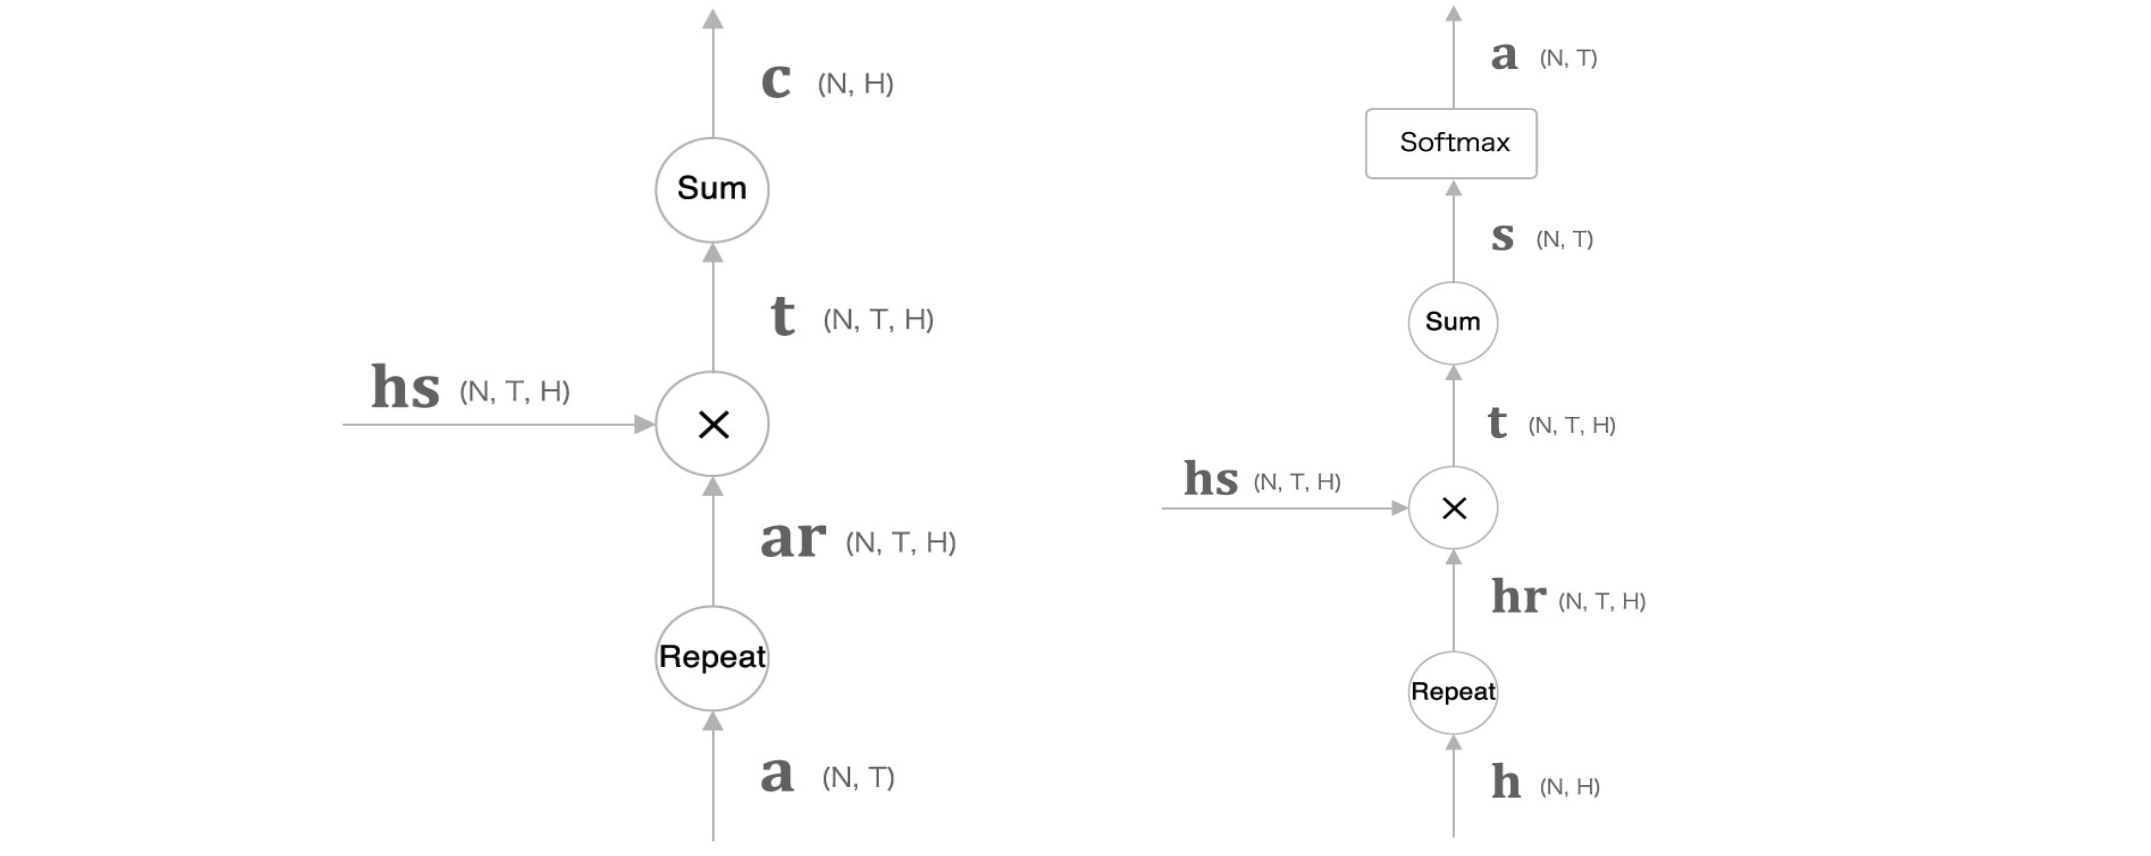

In [ ]:
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx


class AttentionWeight:
    def __init__(self):
        self.params, self.grads = [], []
        self.softmax = Softmax()
        self.cache = None

    def forward(self, hs, h):
        N, T, H = hs.shape

        hr = h.reshape(N, 1, H)#.repeat(T, axis=1)
        t = hs * hr
        s = np.sum(t, axis=2)
        a = self.softmax.forward(s)

        self.cache = (hs, hr)
        return a

    def backward(self, da):
        hs, hr = self.cache
        N, T, H = hs.shape

        ds = self.softmax.backward(da)
        dt = ds.reshape(N, T, 1).repeat(H, axis=2)
        dhs = dt * hr
        dhr = dt * hs
        dh = np.sum(dhr, axis=1)

        return dhs, dh


class WeightSum:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, hs, a):
        # 'ppp' exercise
        N, T, H = hs.shape

        ar = a.reshape(N, T, 1)
        t = hs * ar
        o = np.sum(t, axis=1)

        self.cache = (hs, ar)
        return c

    def backward(self, dc):
        # 'ppp' exercise
        hs, ar = self.cache
        N, T, H = hs.shape
        dt = dc.resahpe(N, 1, H).repeat(T, axis=1)
        dar = dt * hs
        dhs = dt * ar
        da = np.sum(dar, axis=2)

        return dhs, da



In [ ]:
class Attention:
    def __init__(self):
        self.params, self.grads = [], []
        self.attention_weight_layer = AttentionWeight()
        self.weight_sum_layer = WeightSum()
        self.attention_weight = None

    def forward(self, hs, h):
        a = self.attention_weight_layer.forward(hs, h)
        out = self.weight_sum_layer.forward(hs, a)
        self.attention_weight = a
        return out

    def backward(self, dout):
        dhs0, da = self.weight_sum_layer.backward(dout)
        dhs1, dh = self.attention_weight_layer.backward(da)
        dhs = dhs0 + dhs1
        return dhs, dh


class TimeAttention:
    def __init__(self):
        self.params, self.grads = [], []
        self.layers = None
        self.attention_weights = None

    def forward(self, hs_enc, hs_dec):
        # 'ppp' exercise
        N, T, H = hs_enc
        out = np.empty_like(hs_dec)
        self.layers = []
        self.attention_weight = []

        for t in range(T):
          layer = Attention()
          out[:, t, :] = layer.forward(hs_enc, hs_dec[:, t, :])
          self.layer.append(layer)
          self.attention_weight.append(layer.attention_weight)
        return out

    def backward(self, dout):
        # 'ppp' exercise
        N, T, H = dout.shape
        dhs_enc = 0
        dhs_dec = np.empty_like(dout)

        for t in range(T):
          layer = self.layers[t]
          dhs, dh = layer.backword(dout[:, t, :])
          dhs_enc += dhs
          dhs_dec[:, t, :] = dh
        return dhs_enc, dhs_dec

In [ ]:
class AttentionSeq2seq(Seq2seq):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        args = vocab_size, wordvec_size, hidden_size
        self.encoder = AttentionEncoder(*args)
        self.decoder = AttentionDecoder(*args)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads


class AttentionEncoder(Encoder):
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        return hs

    def backward(self, dhs):
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout


class AttentionDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(2*H, V) / np.sqrt(2*H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.attention = TimeAttention()
        self.affine = TimeAffine(affine_W, affine_b)
        layers = [self.embed, self.lstm, self.attention, self.affine]

        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, enc_hs):
        # 'ppp' exercise
        h = enc_hs[:,-1]
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        dec_hs = self.lstm.forward(out)
        c = self.attention.forward(enc_hs, dec_hs)
        out = np.concatenate((c, dec_hs), axis=2)
        score = self.affine.forward(out)
        return score


    def backward(self, dscore):
        # 'ppp' exercise
        dout = self.affine.backward(dscore)
        N, T, H2 = dout.shape
        H = H2 //2

        dc, ddec_hs0 = dout[:, :, :H], dout[: ,: H:]
        denc_hs. ddec_hs1 = self.attention.backward(dc)
        ddec_hs = ddec_hs0 + ddec_hs1
        dout = self.lstm.backward(ddec_hs)
        dh =self.lstm.dh
        denc_hs[:, -1] += dh
        self.embed.backward(dout)
        return denc_hs

    def generate(self, enc_hs, start_id, sample_size):
        # 'ppp' exercise
        sampled = []
        sample_id = start_id
        h = enc_hs[:-1]
        self.lstm.set_state(h)

        for _ in range(sample_size):
          x = np.array([sample_id]).reshape((1,1))
          out = self.embed.forward(x)
          dec_hs = self.lstm.forwad(out)
          c = self.attetion.forward(enc_hs, dec_hs)
          out = np.concatenate((c, dec_hs), axis=2)
          score = self.affine.forward(out)

          sample_id = np.argmax(score.flatten())
          sampled.append(sample_id)

        return sampled


Done
| epoch 1 |  iters 1 / 351 | time 0[s] | loss 2.56
| epoch 1 |  iters 21 / 351 | time 3[s] | loss 2.44
| epoch 1 |  iters 41 / 351 | time 6[s] | loss 2.04
| epoch 1 |  iters 61 / 351 | time 10[s] | loss 1.92
| epoch 1 |  iters 81 / 351 | time 12[s] | loss 1.87
| epoch 1 |  iters 101 / 351 | time 15[s] | loss 1.81
| epoch 1 |  iters 121 / 351 | time 17[s] | loss 1.79
| epoch 1 |  iters 141 / 351 | time 19[s] | loss 1.78
| epoch 1 |  iters 161 / 351 | time 23[s] | loss 1.78
| epoch 1 |  iters 181 / 351 | time 26[s] | loss 1.78
| epoch 1 |  iters 201 / 351 | time 28[s] | loss 1.76
| epoch 1 |  iters 221 / 351 | time 31[s] | loss 1.75
| epoch 1 |  iters 241 / 351 | time 33[s] | loss 1.75
| epoch 1 |  iters 261 / 351 | time 35[s] | loss 1.76
| epoch 1 |  iters 281 / 351 | time 39[s] | loss 1.75
| epoch 1 |  iters 301 / 351 | time 42[s] | loss 1.74
| epoch 1 |  iters 321 / 351 | time 44[s] | loss 1.74
| epoch 1 |  iters 341 / 351 | time 46[s] | loss 1.73
Q 77+85  
T 162 
☒ 100 
---
Q 97

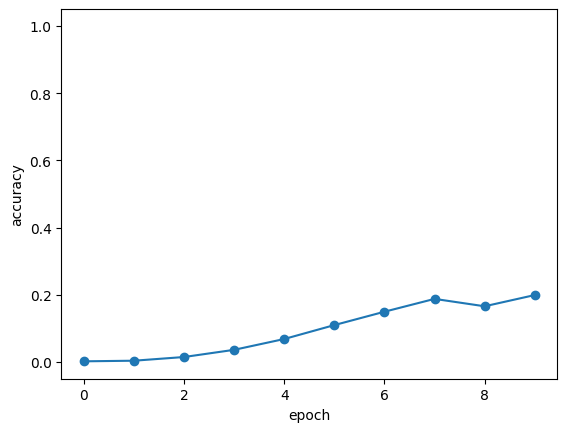

In [ ]:
# data preparation
(x_train, t_train), (x_test, t_test) = load_data('date.txt')
char_to_id, id_to_char = get_vocab()
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]

# hyperparameters
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 256
batch_size = 128
max_epoch = 10
max_grad = 5.0

model = AttentionSeq2seq(vocab_size, wordvec_size, hidden_size)
# model = Seq2seq(vocab_size, wordvec_size, hidden_size)
# model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)

optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse=True)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('accuracy %.3f%%' % (acc * 100))


# model.save_params()

# visualize results
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(-0.05, 1.05)
plt.show()

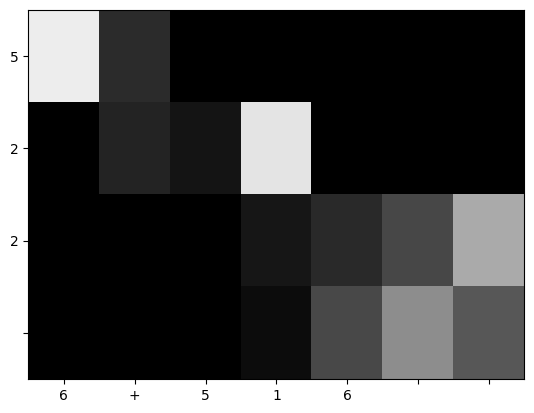

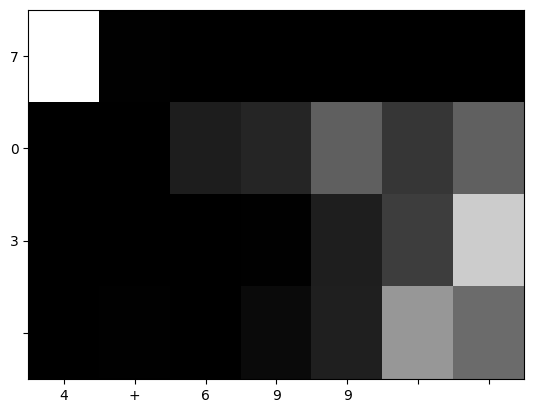

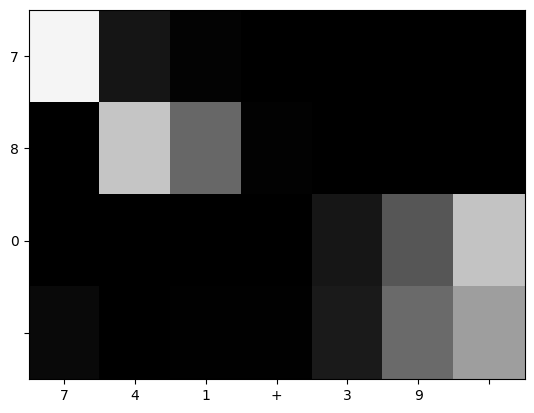

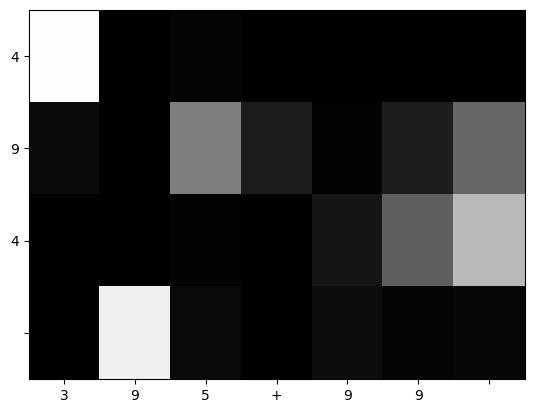

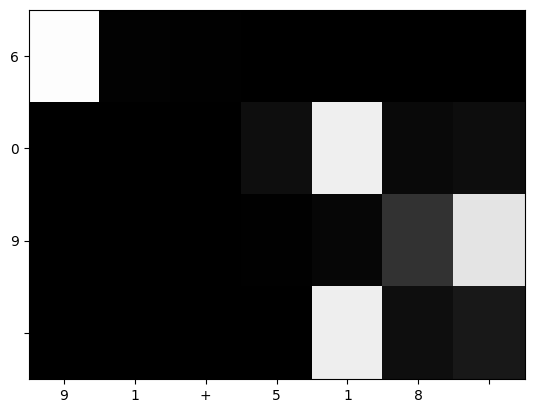

In [ ]:
_idx = 0
def visualize(attention_map, row_labels, column_labels):
    fig, ax = plt.subplots()
    ax.pcolor(attention_map, cmap=plt.cm.Greys_r, vmin=0.0, vmax=1.0)

    ax.patch.set_facecolor('black')
    ax.set_yticks(np.arange(attention_map.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(attention_map.shape[1])+0.5, minor=False)
    ax.invert_yaxis()
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False)

    global _idx
    _idx += 1
    plt.show()


np.random.seed(1984)
for _ in range(5):
    idx = [np.random.randint(0, len(x_test))]
    x = x_test[idx]
    t = t_test[idx]

    model.forward(x, t)
    d = model.decoder.attention.attention_weights
    d = np.array(d)
    attention_map = d.reshape(d.shape[0], d.shape[2])

    # recover the order
    attention_map = attention_map[:,::-1]
    x = x[:,::-1]

    row_labels = [id_to_char[i] for i in x[0]]
    column_labels = [id_to_char[i] for i in t[0]]
    column_labels = column_labels[1:]

    visualize(attention_map, row_labels, column_labels)